# Breast Cancer Data Classification

### Attribute Information
1. Class: no-recurrence-events, recurrence-events
2. age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
3. menopause: lt40, ge40, premeno.
4. tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59.
5. inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39.
6. node-caps: yes, no.
7. deg-malig (degree of malignancy): 1, 2, 3.
8. breast: left, right.
9. breast-quad: left-up, left-low, right-up, right-low, central.
10. irradiate: yes, no.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

# Library classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Library model selection and metrics
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# D-Tree Plot
from sklearn.tree import export_graphviz  
from IPython.display import Image
import pydotplus

# Ignore Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

D:\College\Anaconda\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
col_names_bc = ['class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 
             'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiate']

bc_data = pd.read_csv('breast-cancer.data',
                      delimiter=None,
                      names=col_names_bc,
                      skipinitialspace=True,
                      na_values=["?"])
bc_data.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


## Data Preprocessing

Mencari null data jika ada

In [3]:
bc_data.isnull().sum()

class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiate      0
dtype: int64

In [4]:
percent = bc_data.isnull().sum()/bc_data.shape[0]*100
percent.sort_values(ascending=False)

node-caps      2.797203
breast-quad    0.349650
irradiate      0.000000
breast         0.000000
deg-malig      0.000000
inv-nodes      0.000000
tumor-size     0.000000
menopause      0.000000
age            0.000000
class          0.000000
dtype: float64

Persentase terbesar missing value berdasarkan kolom adalah 2.79% dalam kumpulan data, dan sebagian besar kolom cukup lengkap. Oleh karena itu, akan lebih baik untuk menghapus nilai NaN daripada menghitung secara manual.

In [5]:
bc_data = bc_data.dropna(axis=0, how='any')

In [6]:
bc_data.isnull().sum()

class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiate      0
dtype: int64

In [7]:
bc_data[bc_data.isnull().any(axis = 1)]

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate


### Encode Values to Numerical

In [8]:
cleaned_data = bc_data.copy()

# Membuat nilai pada kolom 'node-caps, irradiate, dan class' menjadi binary
cleaned_data['node-caps']= (cleaned_data['node-caps']=='yes').astype(int)
cleaned_data['irradiate']= (cleaned_data['irradiate']=='yes').astype(int)
cleaned_data['class']= (cleaned_data['class']=='recurrence-events').astype(int)

cleaned_data.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate
0,0,30-39,premeno,30-34,0-2,0,3,left,left_low,0
1,0,40-49,premeno,20-24,0-2,0,2,right,right_up,0
2,0,40-49,premeno,20-24,0-2,0,2,left,left_low,0
3,0,60-69,ge40,15-19,0-2,0,2,right,left_up,0
4,0,40-49,premeno,0-4,0-2,0,2,right,right_low,0


In [9]:
# Encode nilai string pada kolom 'breast-quad' menjadi angka.
quad = {'left_up':1, 'left_low': 2, 'right_up':3, 'right_low':4, 'central':5} 
cleaned_data = cleaned_data.replace({'breast-quad': quad})
cleaned_data['breast-quad'] = cleaned_data['breast-quad'].apply(pd.to_numeric, downcast='float', errors='coerce')
cleaned_data[cleaned_data.isnull().any(axis = 1)]
cleaned_data = cleaned_data.dropna()
cleaned_data.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate
0,0,30-39,premeno,30-34,0-2,0,3,left,2,0
1,0,40-49,premeno,20-24,0-2,0,2,right,3,0
2,0,40-49,premeno,20-24,0-2,0,2,left,2,0
3,0,60-69,ge40,15-19,0-2,0,2,right,1,0
4,0,40-49,premeno,0-4,0-2,0,2,right,4,0


In [10]:
# Encode nilai string pada kolom 'breast'
breast = {'left':1, 'right':2} 
cleaned_data = cleaned_data.replace({'breast': breast})
cleaned_data.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate
0,0,30-39,premeno,30-34,0-2,0,3,1,2,0
1,0,40-49,premeno,20-24,0-2,0,2,2,3,0
2,0,40-49,premeno,20-24,0-2,0,2,1,2,0
3,0,60-69,ge40,15-19,0-2,0,2,2,1,0
4,0,40-49,premeno,0-4,0-2,0,2,2,4,0


In [11]:
# Encode nilai string pada kolom 'menopause'
menopause = {'premeno':1, 'ge40': 2, 'lt40':3} 
cleaned_data = cleaned_data.replace({'menopause': menopause})
cleaned_data.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate
0,0,30-39,1,30-34,0-2,0,3,1,2,0
1,0,40-49,1,20-24,0-2,0,2,2,3,0
2,0,40-49,1,20-24,0-2,0,2,1,2,0
3,0,60-69,2,15-19,0-2,0,2,2,1,0
4,0,40-49,1,0-4,0-2,0,2,2,4,0


In [12]:
# Mengubah nilai pada kolom 'inv-nodes' menjadi mediannya
nodes = {'0-2':1, '3-5':4,'6-8':7,'9-11':10, '12-14':13,'15-17':16,'18-20':19,'21-23':22,'24-26':25,'27-29':28,'30-32':31,'33-35':34,
        '36-38':37,'39':39}
cleaned_data = cleaned_data.replace({'inv-nodes': nodes})
cleaned_data['inv-nodes']

0      1
1      1
2      1
3      1
4      1
      ..
281    1
282    1
283    1
284    4
285    4
Name: inv-nodes, Length: 277, dtype: int64

In [13]:
# Mengubah nilai pada kolom 'age' menjadi reratanya (mean)
age = {'20-29':24.5, '30-39':34.5,'40-49':44.5,'50-59':54.5, '60-69':64.5,'70-79':74.5,'80-89':84.5,'90-99':94.5}
cleaned_data = cleaned_data.replace({'age': age})
cleaned_data.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate
0,0,34.5,1,30-34,1,0,3,1,2,0
1,0,44.5,1,20-24,1,0,2,2,3,0
2,0,44.5,1,20-24,1,0,2,1,2,0
3,0,64.5,2,15-19,1,0,2,2,1,0
4,0,44.5,1,0-4,1,0,2,2,4,0


In [14]:
# Mengubah nilai pada kolom 'tumor-size' menjadi mediannya 
Tumor = {'0-4':2, '5-9':7,'10-14':12,'15-19':17, '20-24':22,'25-29':27,'30-34':32,'35-39':37,'40-44':42,'45-49':47,'50-54':52}
cleaned_data = cleaned_data.replace({'tumor-size': Tumor})
cleaned_data.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate
0,0,34.5,1,32,1,0,3,1,2,0
1,0,44.5,1,22,1,0,2,2,3,0
2,0,44.5,1,22,1,0,2,1,2,0
3,0,64.5,2,17,1,0,2,2,1,0
4,0,44.5,1,2,1,0,2,2,4,0


## Data Visualization

class
0    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

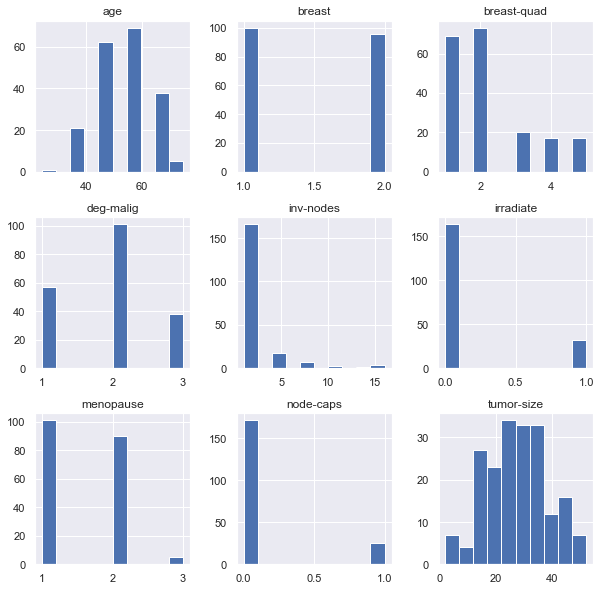

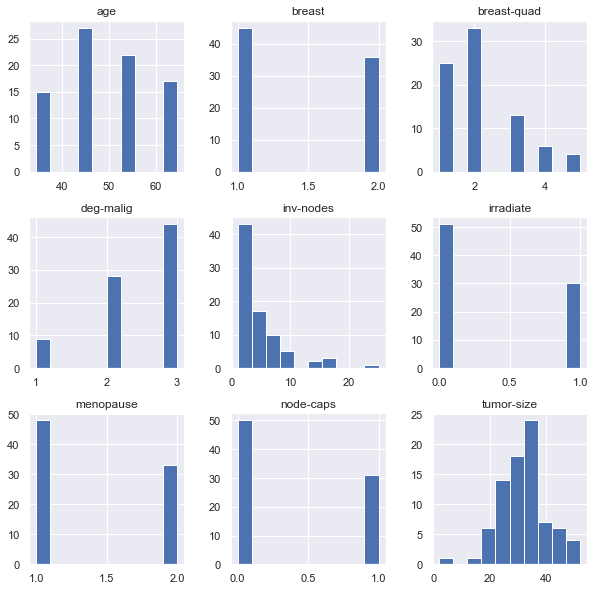

In [15]:
cleaned_data.groupby('class').hist(figsize=(10, 10))

## Features Engineering
Mengekstrak fitur yang diperlukan untuk klasifikasi

In [16]:
features = cleaned_data.drop(['class','irradiate'], axis=1)
labels = cleaned_data['class']

In [17]:
features.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad
0,34.5,1,32,1,0,3,1,2
1,44.5,1,22,1,0,2,2,3
2,44.5,1,22,1,0,2,1,2
3,64.5,2,17,1,0,2,2,1
4,44.5,1,2,1,0,2,2,4


## Training Classifier

### Data Splitting

In [79]:
features_train,features_test,labels_train,labels_test = train_test_split(features,labels,test_size=0.3,random_state=128)

In [80]:
print(features_train.shape, features_test.shape, labels_train.shape, labels_test.shape)

(193, 8) (84, 8) (193,) (84,)


### Check if class is imbalance

In [81]:
print('No Recurrence: {}, Recurrence: {}'.format(sum(labels_train==1),sum(labels_train==0)))

No Recurrence: 56, Recurrence: 137


Terlihat bahwa kelas tidak seimbang ***(imbalance),*** maka akan dilakukan _resampling_ menggunakan SMOTE

In [82]:
sm = SMOTE(random_state=2)
features_train_res, labels_train_res = sm.fit_sample(features_train, labels_train)
features_test_res, labels_test_res = sm.fit_sample(features_test, labels_test)

In [83]:
print("Setelah resampling...\nNo Recurrence: {}, Recurrence: {}".format(sum(labels_train_res==1), sum(labels_train==0)))

Setelah resampling...
No Recurrence: 137, Recurrence: 137


In [84]:
print(features_test_res.shape, features_test_res.shape, labels_train_res.shape, labels_test_res.shape)

(118, 8) (118, 8) (274,) (118,)


## Create Classification Model

In [85]:
models = {1:'Gaussian Naive Bayes',
          2:'Decision Tree'}

### _Gaussian Naive Bayes Classifier_

In [86]:
choice = 1

if choice == 1:
    bc_classifier1 = GaussianNB()
    print('Parameters currently in use in {}:\n'.format(models[choice]))
    print(bc_classifier1)
elif choice == 2:
    bc_classifier2 = DecisionTreeClassifier(random_state=8)
    print('Parameters currently in use in {}:\n'.format(models[choice]))
    pprint(bc_classifier2.get_params())

Parameters currently in use in Gaussian Naive Bayes:

GaussianNB()


### Model fit and performance

In [87]:
bc_classifier_nb = bc_classifier1
bc_classifier_nb.fit(features_train_res, labels_train_res)

GaussianNB()

#### Prediksi Data Train

In [88]:
bc_nb_pred_train = bc_classifier_nb.predict(features_train)
bc_nb_pred_train[:10]

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0])

In [89]:
labels_train[:10]

262    1
168    0
208    1
92     0
24     0
185    0
7      0
80     0
22     0
57     0
Name: class, dtype: int32

In [90]:
accuracy_score(y_true = labels_train, y_pred = bc_nb_pred_train)

0.7305699481865285

#### Prediksi Data Test

In [91]:
bc_nb_pred_test = bc_classifier_nb.predict(features_test)
bc_nb_pred_test[:10]

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1])

In [92]:
labels_test[:10]

195    0
258    1
69     0
245    1
217    1
96     0
124    0
169    0
251    1
278    1
Name: class, dtype: int32

In [93]:
accuracy_score(y_true = labels_test, y_pred = bc_nb_pred_test)

0.6428571428571429

In [94]:
d = {
     'Model': 'Gaussian Naïve Bayes',
     'Training Set Accuracy': accuracy_score(y_true = labels_train, y_pred = bc_nb_pred_train),
     'Test Set Accuracy': accuracy_score(y_true = labels_test, y_pred = bc_nb_pred_test)
}

df_models_nb = pd.DataFrame(d, index=[0])
df_models_nb

,Model,Training Set Accuracy,Test Set Accuracy
0,Gaussian Naïve Bayes,0.73057,0.642857


#### Naive Bayes Classification Report

In [95]:
print("Naive Bayes Classification Report\n")
print(classification_report(y_true = labels_test, y_pred = bc_nb_pred_test))

Naive Bayes Classification Report

              precision    recall  f1-score   support

           0       0.80      0.66      0.72        59
           1       0.43      0.60      0.50        25

    accuracy                           0.64        84
   macro avg       0.61      0.63      0.61        84
weighted avg       0.69      0.64      0.66        84



### _Decision Tree Classifier_

In [96]:
bc_choice = 2

if bc_choice == 1:
    bc_classifier1 = GaussianNB()
    print('Parameters currently in use in {}:\n'.format(models[bc_choice]))
    print(bc_classifier1)
elif bc_choice == 2:
    bc_classifier2 = DecisionTreeClassifier(random_state=8)
    print('Parameters currently in use in {}:\n'.format(models[bc_choice]))
    pprint(bc_classifier2.get_params())

Parameters currently in use in Decision Tree:

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 8,
 'splitter': 'best'}


### Decision Tree Cross Validation for Hyperparameter Tuning
Let's fit a decision tree model and optimize its hyperparameters using a **grid search**. We shall perform a grid search over split criterion, maximum depth, and minimum samples split parameters.

In [97]:
bc_classifier_dtree = bc_classifier2
bc_params_grid_dtree = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
             'min_samples_split': [2, 3]}

bc_cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

bc_grid_search_dtree = GridSearchCV(estimator=bc_classifier_dtree, 
                     param_grid=bc_params_grid_dtree, 
                     cv=bc_cv_sets,
                     verbose=1, 
                     scoring='accuracy')

bc_grid_search_dtree.fit(features_train_res, labels_train_res)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:    0.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=DecisionTreeClassifier(random_state=8),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_split': [2, 3]},
             scoring='accuracy', verbose=1)

In [98]:
print("The best hyperparameters from Random Search are:")
print(bc_grid_search_dtree.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(bc_grid_search_dtree.best_score_)

The best hyperparameters from Random Search are:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}

The mean accuracy of a model with these hyperparameters is:
0.7032967032967034


In [99]:
bc_best_classifier_dtree = bc_grid_search_dtree.best_estimator_
bc_best_classifier_dtree

DecisionTreeClassifier(max_depth=5, random_state=8)

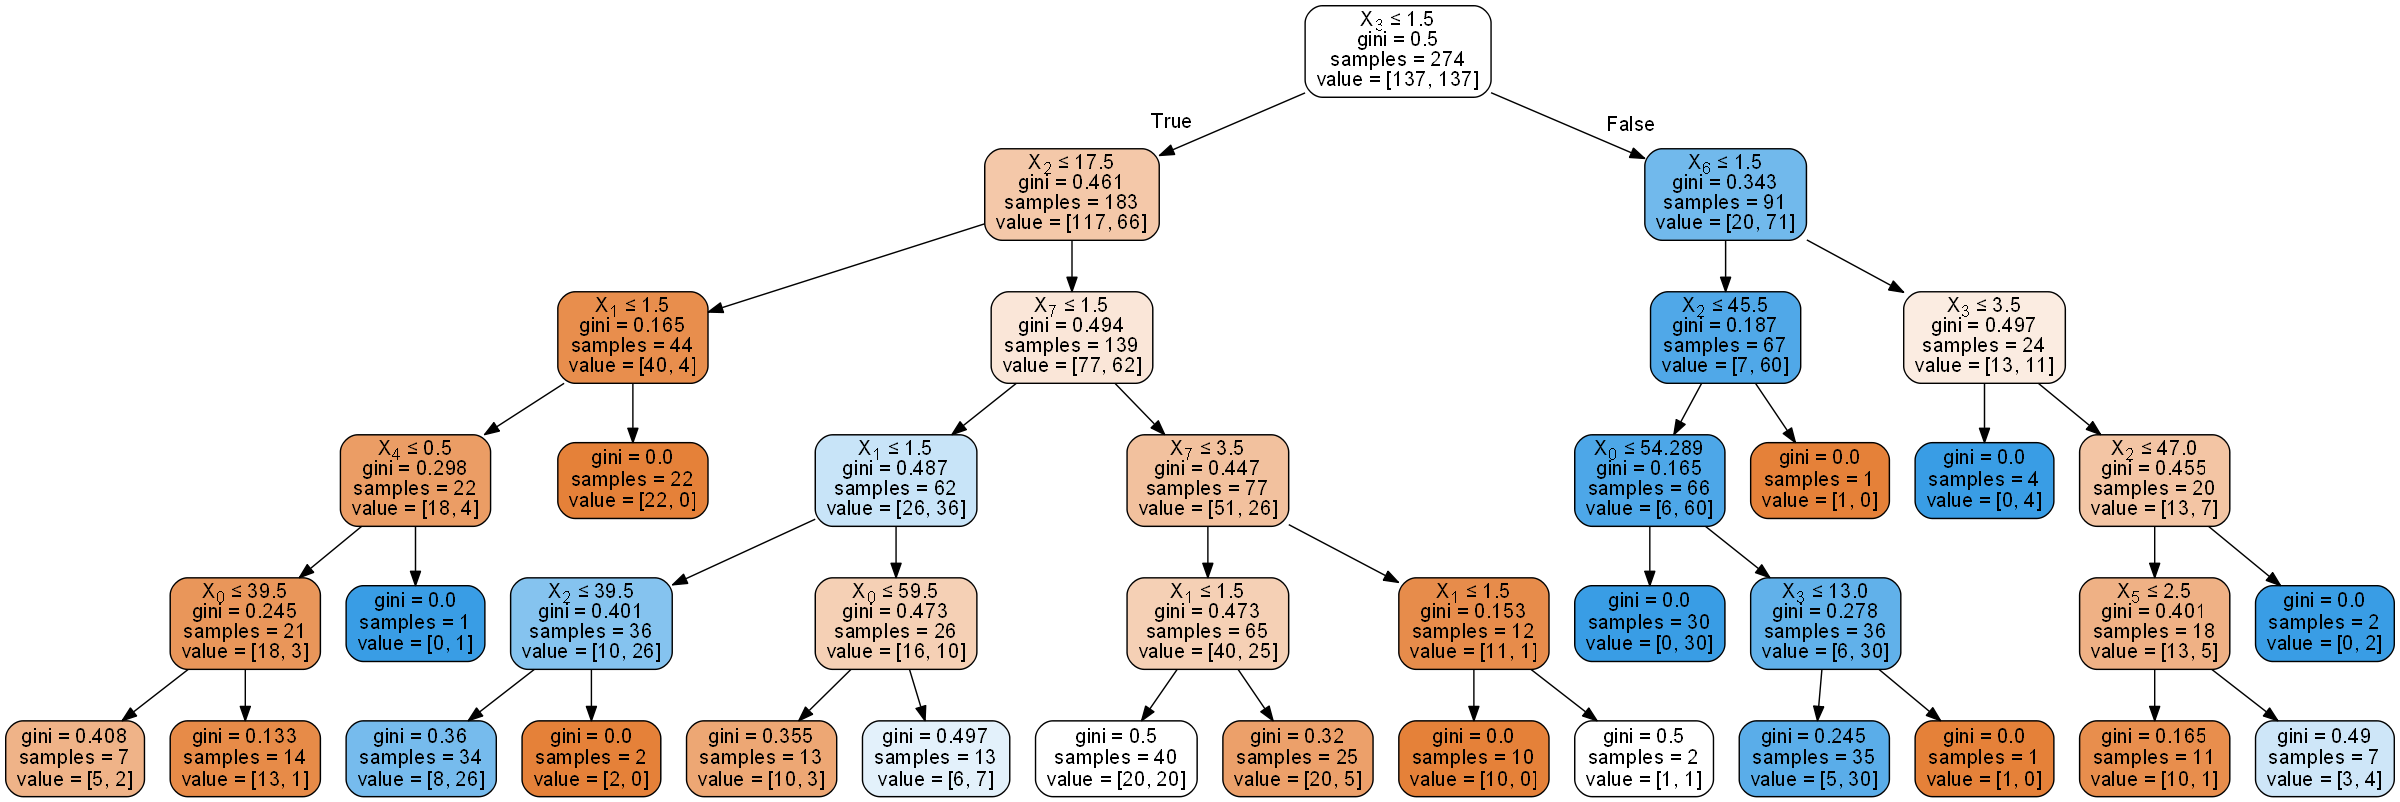

In [100]:
from io import StringIO
dot_data = StringIO()

export_graphviz(bc_best_classifier_dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.set_size('"25!"')
graph.write_png('Breast-Cancer-Dtree.png')
Image(graph.create_png())

### Model fit and performance

In [101]:
bc_best_classifier_dtree.fit(features_train_res, labels_train_res)

DecisionTreeClassifier(max_depth=5, random_state=8)

#### Prediksi Data Train

In [102]:
bc_dtree_pred_train = bc_best_classifier_dtree.predict(features_train)
bc_dtree_pred_train[:10]

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [103]:
labels_train[:10]

262    1
168    0
208    1
92     0
24     0
185    0
7      0
80     0
22     0
57     0
Name: class, dtype: int32

In [104]:
accuracy_score(y_true = labels_train, y_pred = bc_dtree_pred_train)

0.7823834196891192

#### Prediksi Data Test

In [105]:
bc_dtree_pred_test = bc_best_classifier_dtree.predict(features_test)
bc_dtree_pred_test[:10]

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1])

In [106]:
labels_test[:10]

195    0
258    1
69     0
245    1
217    1
96     0
124    0
169    0
251    1
278    1
Name: class, dtype: int32

In [107]:
accuracy_score(y_true = labels_test, y_pred = bc_dtree_pred_test)

0.6547619047619048

#### Decision Tree Classification Report

In [108]:
d = {
     'Model': 'Decision Tree',
     'Training Set Accuracy': accuracy_score(y_true = labels_train, y_pred = bc_dtree_pred_train),
     'Test Set Accuracy': accuracy_score(y_true = labels_test, y_pred = bc_dtree_pred_test)
}

df_models_dtree = pd.DataFrame(d, index=[0])
df_models_dtree

,Model,Training Set Accuracy,Test Set Accuracy
0,Decision Tree,0.782383,0.654762


In [109]:
print("Decision Tree Classification Report\n")
print(classification_report(y_true = labels_test, y_pred = bc_dtree_pred_test))

Decision Tree Classification Report

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        59
           1       0.41      0.36      0.38        25

    accuracy                           0.65        84
   macro avg       0.58      0.57      0.57        84
weighted avg       0.64      0.65      0.65        84



### Comparisons between classifiers

In [110]:
bc_comparison = pd.DataFrame({
    'CLASSIFIER' : ['Naive Bayes','Decision Tree'],
    'Train Set Accuracy' : [accuracy_score(y_true = labels_train, y_pred = bc_nb_pred_train),
                           accuracy_score(y_true = labels_train, y_pred = bc_dtree_pred_train)],
    'Test Set Accuracy' : [accuracy_score(y_true = labels_test, y_pred = bc_nb_pred_test), 
                           accuracy_score(y_true = labels_test, y_pred = bc_dtree_pred_test)]
})

bc_index = bc_comparison.index
bc_index.name = "Breast Cancer Classification"
bc_comparison

,CLASSIFIER,Train Set Accuracy,Test Set Accuracy
Breast Cancer Classification,,,
0,Naive Bayes,0.730570,0.642857
1,Decision Tree,0.782383,0.654762


**Credit**: Naufal Hilmiaji